# Physics-Informed Neural Networks (PINN)

This notebook is based off the blog post ["So, what is a physics-informed neural network?"](https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/)

Within much of the sustainability domain we heavily rely on physically based equations. They are found throughout socio (e.g. evolutionary dynamics), economic (e.g. heterogeneous macro-economics), and environmental (e.g. thermodynamics, fluid dynamics, etc) problems and are the ways in which humans have traditionally quantified the world around them.

With the advacement of data-driven methods using ML we are now able to infer realistic behaviour from large swathes of data alone, without the need to rely on computationally heavy equations.
For instance many climate simulations rely on the Navier-Stokes equations for fluid dynamics, which are computationally difficult to solve as fluid turbulence modelling requires a small scale (in the mm/cm), yet the overall picture may be a much larger scale (e.g. Ocean modelling).

However as common with much of the ML domain, data is generally incomplete or very noisy. Relate this to real world monitoring where sensors are largely innacurate and when immersed in challenging environments such as the saline ocean can lead to reduced performance.

In this notebook we hope to introduce you to Physics Informed Neural Networks (PINN) as a potential solution to take the benefits from both data only, and physics only based approaches. Here we are focusing on quite a simplistic PINN case as it permits a deeper understanding and easier visualisation of the problem. However techniques learnt here can apply to many other domains that have traditionally been modelled with Ordinary Differential Equations (ODEs) or Partial Differential Equations (PDEs).


We are going to look at a 1D underdamped oscillatory motion which is defined by the following ODE. Do not worry too much if you don't understand the equation, just recognise it as a function that defines the relationship between time $t$ and position $x$ of a particle/system/agent over an infinite time horizon:

$$
m \dfrac{d^2 x}{d t^2} + c \dfrac{d x}{d t} + kx = 0~,
$$
where $m$ is the mass of the oscillator, $c$ is the coefficient of friction, and $k$ is the spring constant. Examples of this are a weight on a spring, a pendulum initiated from a height, or even a piano/harp etc. stringed instrument.


![oscillator gif](https://benmoseley.blog/wp-content/uploads/2021/08/oscillator.gif)

The objects (e.g. the mass in this example) starts at the set initial conditions:
$$
\begin{aligned}
x(0) &= 1 \quad \text{i.e. y=1 at the start position}\\
\dot{x}(0) &= 0 \quad \text{i.e. no initial velocity }
\end{aligned}
$$

where $\dot{x} = \frac{dx}{dt}$ and $\ddot{x} = \frac{d^2x}{dt^2}$

This has the following exact solution obtained through solving the ODE through twice differentiation:
$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$

where for an underamped state:
$$
\delta < \omega_0~,~\delta = \dfrac{c}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$

This exact solution will be used to create some non-linear data. However, we want to learn an approximation of this solution from a data driven approach. We know Neural Networks (NN) to be great genearlisable function approximators,so it makes sense to try one as a first step to infer this physics based equation.


## Environment set up

You do not need a GPU for this tutorial.

As before please do not edit cells that contain \\
"### DO NOT EDIT THIS CELL"  \\
but add code at the required locations marked by \\
"### PLEASE ADD YOUR CODE HERE"

We train the PINN using PyTorch with the following packages plus helper functions:

In [ ]:
## DO NOT EDIT THIS CODE CELL

import sys
import os

from PIL import Image

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


path = "./plots/"
if not os.path.exists(path):
   # Create a new directory because it does not exist
   os.makedirs(path)
   print("The new directory is created!")


def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

def plot_result(x,y,x_data,y_data,yh,xp=None,training_step=0):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x.cpu(),y.cpu(), color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x.cpu(),yh.cpu(), color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data.cpu(), y_data.cpu(), s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp.cpu(), -0*torch.ones_like(xp.cpu()), s=60, color="tab:green", alpha=0.4,
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065,0.7,"Training step: %i"%(training_step+1),fontsize="xx-large",color="k")
    plt.axis("off")

The new directory is created!


## Generate training data

> First, we generate some training data including noise from a small part of the true analytical solution. The model will need to greatly infer the later timesteps within our set domain as well as develop an understanding of the true underlying dynamic irrelevant of the added noise.

For this problem, we use $\delta=2$, $\omega_0=20$, and try to learn the solution over the domain $x\in [0,1]$. We use the exact analytical solution to derive this data but also incorporate some noise.

torch.Size([500, 1]) torch.Size([500, 1])


torch.Size([40, 1]) torch.Size([40, 1])


<Figure size 640x480 with 0 Axes>

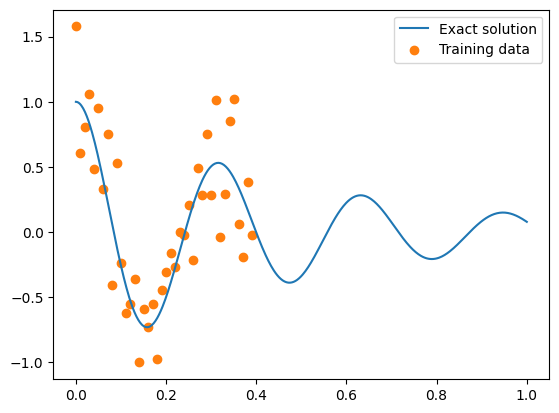

In [ ]:
## DO NOT EDIT THIS CODE CELL
def oscillator(d, w0, x):
    """Defines the exact analytical solution to the 1D underdamped harmonic oscillator problem.
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

d, w0 = 2, 20

# get the analytical solution over the full domain
x = torch.linspace(0,1,500).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)
print(x.shape, y.shape)

# creating some gaussian noise
torch.manual_seed(42)
sigma = 0.3
noise = y + torch.normal(0.0, sigma, y.shape)

# slice out a small number of points from the LHS of the domain
x_data = x[0:200:5]
y_data = noise[0:200:5]
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

## Vanilla Neural Network

> Next, we train a standard fully connected NN to fit these training points using mean squared error.

The standard activation function used is normally a ReLU function, however within this physics based domain we are minimising a loss on the gradients of the network. Therefore any activation function we use needs to be differentiable everywhere for appropriate continuous gradients. This excludes ReLU as it is piecewise linear and prevents continuous gradients. It is prefferable to use Tanh or GeLU (Gaussian Error Linear Unit).

We will be using PyTorch for this implementation and have left gaps for you to fill in the following code cell:

torch.Size([40, 1]) torch.Size([40, 1])
500 Training Steps Completed
1000 Training Steps Completed


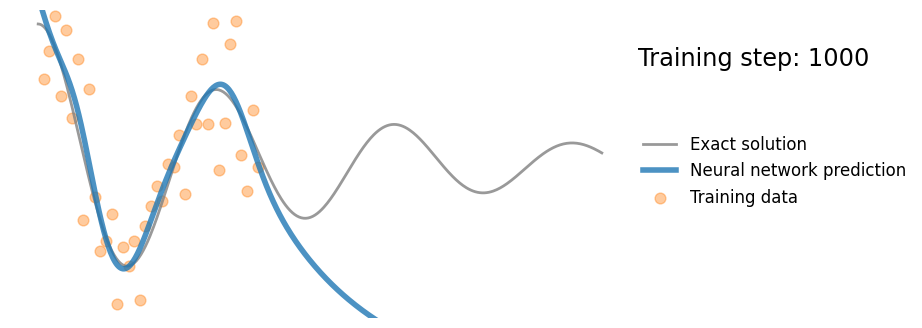

In [ ]:
### PLEASE ADD YOUR CODE HERE

class FCN(nn.Module):
    ### Implement a fully connected neural network consisting 3 linear layers
    ### with tanh/gelu activation funcation and then a final linear layer
    "Defines a fully connected network"
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()

        # 3 linear layers and a final layer
        self.L1 = nn.Linear(n_input, n_hidden)
        self.L2 = nn.Linear(n_hidden, n_hidden)
        self.L3 = nn.Linear(n_hidden, n_hidden)
        self.final = nn.Linear(n_hidden, n_output)

    def forward(self, x):
        # incorporate the 3 linear layers with our activation function with a subsequent final layer
        x = F.gelu(self.L1(x))
        x = F.gelu(self.L2(x))
        x = F.gelu(self.L3(x))
        x = self.final(x)
        return x

# data to edit for the discussion section
# creating some Gaussian noise
torch.manual_seed(42)
sigma = 0.3
noise = y + torch.normal(0.0, sigma, y.shape)

# slice out a small number of points from the LHS of the domain
x_data = x[0:200:5]
y_data = noise[0:200:5]
print(x_data.shape, y_data.shape)


def train_nn(x, y, x_data, y_data, training_length):
    torch.manual_seed(42)
    model = FCN(1,1,32)

    ### Please add an Adam optimiser with learning rate 1e-3
    optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
    files = []
    for i in range(training_length):
        ### Add the usual training loop, i.e. zero grad then feed forward data
        optimiser.zero_grad()
        yh = model(x_data)

        ### Implement the MSE loss below, then backpropagate, next take a step
        ### in the optimiser
        loss = torch.mean((yh-y_data)**2)  # mean squared error implementation
        loss.backward()
        optimiser.step()

        if i+1 == training_length:
            yh = model(x).detach()
            plot_result(x, y, x_data, y_data, yh, training_step=i)
            file = "plots/nn_%.8i.png"%(i+1)
            plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")

        if (i+1) % 500 == 0:
          print("{} Training Steps Completed".format(i+1))

training_steps = 1000
train_nn(x, y, x_data, y_data, training_steps)
# train_nn(x, y, x, noise, training_steps)

Discuss the following questions: \\
1) Try adjusting the noise parameter to see its effect on the models understanding of the data (i.e. how closely it fits the exact solution), for instance adjusting the variance (sigma) or changing the noise generator from a Gaussian \\
2) Similarly adjust the amount of data sliced and the slice spacing to see either attributes effect \\
3) Now try replacing x_data and y_data with the original x and noise data respectivley to obtain training data over the whole domain - what is the model now able to achieve?

It's clear the model has overfit to the noise of the data and ignored the true underlying function. This has lead to relevativley decent interpolation performance but awful extrapolation behaviour. It is as if the model hasn't truly understood the problem - it is unable to infer that this is 1D underdamped oscillatory motion from the limited training data it has been given.

As seen in the discussion we can get a pretty good solution if we give it data for the whole domain, however this is generally infeasible. I.E how can we predict the weather for tomorrow with just the weather of today. Even with all this data the model still struggles to accurately predict the exact solution, for example near the end of our predefined domain.

The key takeaway is our model is heavily dependant on the data given to it reducing its generalisability.

## Regularisation

It is clear the model is overfitting to our data, the usual first step to address this is incorporating regularisation. This is an additional term in our loss that aims to penalise large NN weights with the aim of fitting more closely to the out of sample data. The equation for our new $L_2$ loss function is below:
$$
L_{regularised} = \frac{1}{N} \sum_{i=1}^N ||f(x_i|\theta) - y_i||^2_{L_2} + \lambda || \theta ||_{L_2}^2
$$

where $\lambda$ is the regularisation coeffiecient that sets the bound, $N$ is the set of data points, and $\theta$ are the NN parameters.

Please incoporate this into the following code:

500 Training Steps Completed
1000 Training Steps Completed


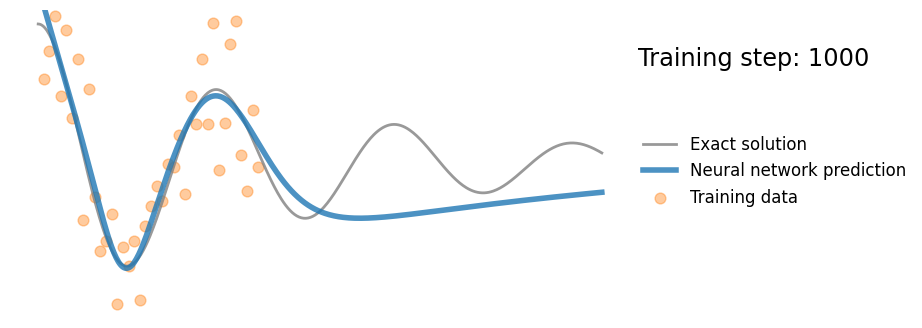

In [ ]:
### PLEASE ADD YOUR CODE HERE

def train_regularised_nn(x, y, x_data, y_data, training_length):

    torch.manual_seed(42)
    model = FCN(1,1,32)
    optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
    files = []
    for i in range(training_length):
        optimiser.zero_grad()
        yh = model(x_data)

        loss_1 = torch.mean((yh-y_data)**2)  # mse loss

        ### Add the L2 regularisation term to the MSE loss, HINT use torch.linalg.norm
        l2_lambda = 0.0002
        l2_reg = torch.sum(sum(torch.linalg.norm(p).pow(2) for p in model.parameters()))
        loss_2 = l2_lambda * l2_reg  # l2 loss

        loss = loss_1 + loss_2
        loss.backward()
        optimiser.step()

        if i+1 == training_length:
            yh = model(x).detach()
            plot_result(x, y, x_data, y_data, yh, training_step=i)
            file = "plots/regularised_nn_%.8i.png"%(i+1)
            plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")

        if (i+1) % 500 == 0:
          print("{} Training Steps Completed".format(i+1))

training_steps = 1000
train_regularised_nn(x, y, x_data, y_data, training_steps)

Discuss the following questions: \\
1) Adjust the regularisation coefficient $\lambda$ noticing the impact of this hyperparameter \\
2) If there is time can you instead incorporate the $L_1$ norm, what effect does this have?

Regularisation has slightly helped prevent some overfitting here to our noisy data, however this still doesn't match the true out of sample behaviour of the data. It still struggles with extrapolating

## PINN

> Finally, we add the underlying differential equation into the mix.

We have seen that normal regularisation does not achieve our desired results. Instead we must incorporate our own knowledge about the data (i.e. the fact it has basis within physics) in order for our model to achieve good results. We incorporate this sense of physics based regularisation through editing the loss function. This ensures the learnt function is consistent with the underlying differential equation. Our model loss is now dependent on the data conforming to the ODE so it will update NN parameters in order to achieve this similarity.

This is done by penalising the residual of the differential equation over a set of locations sampled from the domain, thus leading to the following equation:
$$
L_{PINN} = \frac{1}{N} \sum_{i=1}^N ||f(x_i|\theta) - y_i||^2_{L_2} + \lambda \frac{1}{M} \sum_{j=1}^M || g(x_j, f(x_j | \theta) ||_{L_2}^2
$$

where $M$ is the set of *collocation* points, aka locations sampled from the domain, $\lambda$ is a coefficient deciding the strength of the physics-informed regularisation, and $g(\cdot)$ is the physics based loss. Collocation points are used to enable extrpolation of our current data points over the whole of the required domain.

To motivate this Physics Informed $L_2$ regularisation in a different way, the oscillatory ODE can be reorganised to its original force balance:
$$
\underbrace{m \frac{d^2 f(x_j | \theta)}{dx_j^2}}_\text{inertia} = \underbrace{- c \frac{d f(x_j|\theta)}{dx_j}}_\text{friction force} - \underbrace{k}_\text{spring force}
$$
i.e. we want our inertia in one direction to equal the opposing forces of spring constant and friction. This can be reimagined as comparing for example the true data point and the predicted data point. We are aiming to minimise the difference between the two sides of the equation aka reducing the residual. Hopefully this helps further explain the reasoning behind phyiscs based regularisation.

Incorporating our 1D  underdamped oscillatory ODE function as $g(\cdot)$ leads to:
$$
L_{PINN} = \frac{1}{N} \sum_{i=1}^N ||f(x_i|\theta) - y_i||^2_{L_2} + \lambda \frac{1}{M} \sum_{j=1}^M \left( m \frac{d^2 f(x_j | \theta)}{dx_j^2} + c \frac{d f(x_j|\theta)}{dx_j} + k \right)^2
$$


Within this example we evaluate the physics loss at 30 points uniformly spaced over the problem domain $([0,1])$. We can calculate both derivatives of the NN output from the input collocation points using PyTorchs autodifferentiation feature, and then compute the loss.

To do this use the torch.autograd module that has a great function called grad(). Ensure that create_graph is set to $True$ in order to create a new computational graph without reusing an old one.

5000 Training Steps Completed
10000 Training Steps Completed
15000 Training Steps Completed
20000 Training Steps Completed


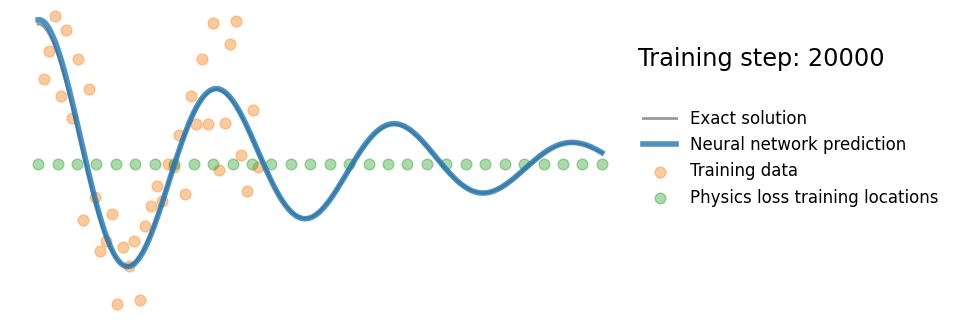

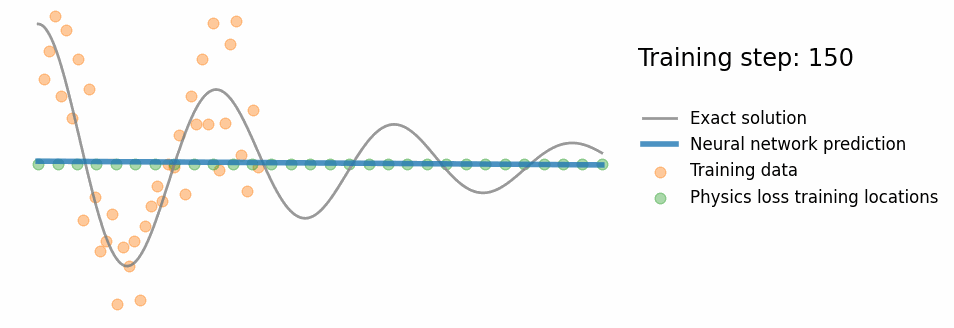

In [ ]:
### PLEASE ADD YOUR CODE HERE

def train_pinn(x, y, x_data, y_data, training_length):
    ### Create below a set of 30 collocation points labelled x_physics, they require grad
    x_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)
    m = 1
    c = 2 * d
    k = w0 ** 2

    ### Below is much of the same from previous sections, loading model and optimiser

    torch.manual_seed(42)
    model = FCN(1,1,32)
    optimiser = torch.optim.Adam(model.parameters(), lr=1e-4)
    files = []
    for i in range(training_length):
        optimiser.zero_grad()

        ### Compute the "data loss", i.e. the MSE
        yh = model(x_data)
        loss1 = torch.mean((yh-y_data)**2)

        ### Next compute the "physics loss". Rather than feeding x_data into the
        ### model, feed in the collocation points. Then compute dy/dx and d^2y/dx^2
        ### using autograd on the physics model output

        ### Using these two differentials, construct the loss from the above equation,
        ### multiply by physics_lambda and then add to the MSE loss.

        physics_lambda = 0.0001
        yhp = model(x_physics)
        dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]  # compute dy/dx
        dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]  # compute d^2y/dx^2
        physics = m*dx2 + c*dx + k*yhp  # computes the residual of the 1D harmonic oscillator differential equation
        loss2 = physics_lambda * torch.mean(physics ** 2)

        # backpropagate joint loss
        loss = loss1 + loss2
        loss.backward()
        optimiser.step()

        if (i+1) % 150 == 0 or (i+1) == training_length:

            yh = model(x).detach()
            xp = x_physics.detach()

            plot_result(x,y,x_data,y_data,yh,xp, training_step=i)

            file = "plots/pinn_%.8i.png"%(i+1)
            plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
            files.append(file)
            plt.close("all")

        if (i+1) % 5000 == 0:
          print("{} Training Steps Completed".format(i+1))

    save_gif_PIL("pinn.gif", files, fps=20, loop=0)

training_steps = 20000
train_pinn(x, y, x_data, y_data, training_steps)

file = "plots/pinn_%.8i.png"%(training_steps)
with open(file,'rb') as f:
    display.Image(data=f.read(), format='png')

with open("pinn.gif",'rb') as f:
    display.Image(data=f.read(), format='png')

### this takes a bit longer to train btw ~3mins

Discuss the following questions: \\
1) Adjust the physics regularisation weighting coefficient $\lambda$, how does this affect the results? \\

Hopefully it's clear how useful this is! We can infer data points for interpolation or even extrapolation that have basis within underlying physics equations.

We have covered how to incorporate these beliefs into our loss function, however other methods exist such as further editing the NN architecture or data inputs. We will not cover these as they are outside the scope of this lab session but we have listed some relevant papers below if you are interested: \\
[Scientific Machine Learning through Physics-Informed Neural Networks: Where we are and What's next](https://arxiv.org/abs/2201.05624)


You might ask though, if we know the underlying equations, and have already solved them numerically to get the exact solution, why even bother using any data. This is a valid point, however generally these equations themselves are huge approximations of real life behaviour, acting as models discovered through experimentation. We already include an assumption that $sin(\theta) \sim \theta$ for the small angles in this experiment, even for this simplistic equation. For more realistic results many adjustment terms can be added to the original equation for example to account for complex wind dynamics on the oscillating mass. These can be computationally heavy. Sometimes there is also no closed-form solution so it is impossible to numerically solve directly.

If this is true then why don't we use pure data approaches? Real world data is heavily stochastic, something that is greatly difficult to model. For a model trained on this data it can sometimes be difficult for it to differentiate between the noise in the data and the underlying dynamics the data is trying to represent.

Hopefully this makes it clear that by inducing physics assumptions into a data driven model we gain the benefits of both:
- Realistic behaviour from data, but with noisy or incomplete datasets
- Classic equations that can interpolate and extrapolate based on simple parameters, but are limited by large assumptions and heavy calculations.

There are some limitations of PINNs. They are limited to data in which you believe there are some underlying equation based dynamics. Research shows that too complex regularisation terms can in fact hinder performace, and finding a balance is key.


For more reading into PINNs I have linked the seminal paper below: \\
[Physics-informed neural networks: A deep learning framework...](https://www.sciencedirect.com/science/article/pii/S0021999118307125)

Also you are not limited in this physical domain to just use NNs, other methods such as Reinforcement Learning, Gaussian Process', Neural Operators etc work great for this suite of problems too: \\
[Fourier Neural Operator for Plasma Modelling](https://arxiv.org/abs/2302.06542)\
[Numerical Gaussian Processes for Time-Dependent and Nonlinear Partial Differential Equations](https://epubs.siam.org/doi/epdf/10.1137/17M1120762) \
[Automating turbulence modelling by multi-agent reinforcement learning](https://www.nature.com/articles/s42256-020-00272-0)